## MNIST Handwritten Digits Recognition

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from sklearn import preprocessing, model_selection, linear_model, pipeline, ensemble, svm, decomposition, manifold, tree
from tensorflow import keras
from custom_objects import decorators

### Getting Data

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
# List the first item of each class
def list_distinct(X, y):
    distinct_items = []
    for i in range(10):
        distinct_items.append(X[y==i][0])
    return distinct_items

In [5]:
# Plot all distinct images
def plot_grid(items, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*2))
    for item, class_, axis in zip(items, range(0,10), axes.flat):
        axis.imshow(item, cmap='binary')
        axis.set_title(class_)
        axis.axis('off')

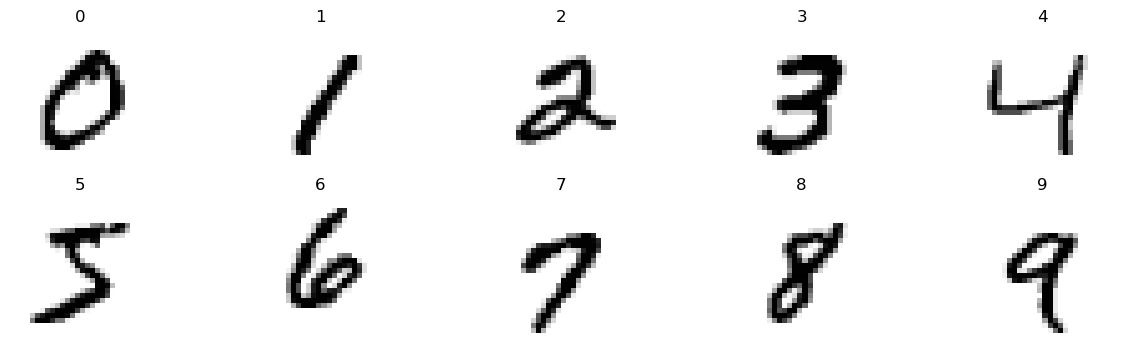

In [6]:
plot_grid(list_distinct(X_train, y_train))

In [9]:
X_train[4]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

### Preprocessing
* Flattening
* Normalization

In [10]:
# Define the function to flatten images
@decorators.sklearn_transformer
def Flatten(X, y=None):
    n = X.shape[0]
    b = X.shape[1:]
    return X.reshape(n, np.prod(b))

In [14]:
# Initial pipeline for flattening and normalization
pre_pipeline = pipeline.Pipeline([('flatten', Flatten),
                                  ('scaler', preprocessing.MinMaxScaler())])

In [15]:
X_prep = pre_pipeline.fit_transform(X_train)

In [16]:
X_prep.shape, X_prep.max()

((60000, 784), 1.0)

#### Visualizing High Dimensional Data

In [17]:
tsne = manifold.TSNE(n_components=2, random_state=42, method='barnes_hut') 

X_viz = tsne.fit_transform(X_prep)

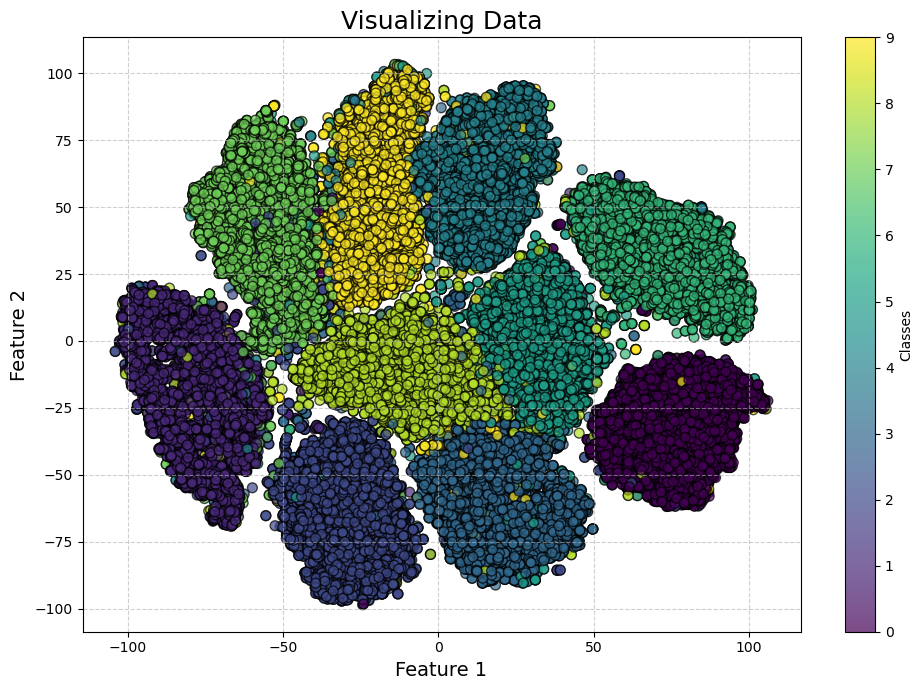

In [22]:
plt.figure(figsize=(10, 7)) 
plt.scatter(X_viz[:, 0], X_viz[:, 1], c=y_train, cmap='viridis', edgecolor='k', alpha=0.7, s=50)  
plt.title('Visualizing Data', fontsize=18)  
plt.xlabel('Feature 1', fontsize=14)  
plt.ylabel('Feature 2', fontsize=14)  
plt.colorbar(label='Classes')  
plt.grid(True, linestyle='--', alpha=0.6) 
plt.tight_layout()  
plt.show()  

In [26]:
def plot_digits(X, y, min_distance=0.04, n_points=5000, images=None, figsize=(13, 10)):
    
    # Shape compatibility and normalization
    X, y = X[:n_points], y[:n_points]
    X = preprocessing.MinMaxScaler().fit_transform(X)
    
    
    # This array stores all the plotted digit images (plus a faraway point to begin with)
    neighbors = np.array([[10., 10.]])
    
    # Scatter plot all points
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X[y == digit, 0], X[y == digit, 1],
                    c=[cmap(float(digit) / 9)], alpha=0.5)
    plt.axis("off")
    
    # Plot actual digits
    ax = plt.gca()  # get current axes
    for index, image_coord in enumerate(X):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is not None:
                images = images[:n_points]
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary", zoom=0.4),
                                          image_coord)
                ax.add_artist(imagebox)

# Code taken from Aurelion Geron's Hands-on ML Book

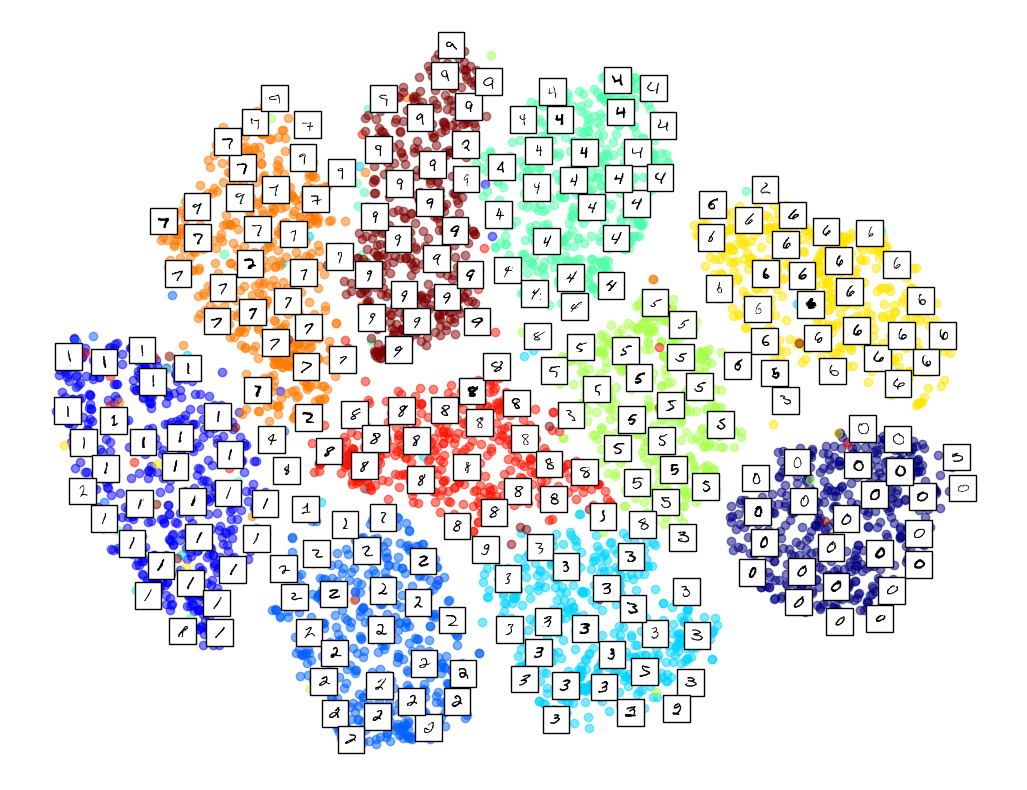

In [27]:
plot_digits(X_viz, y_train, images=X_train)

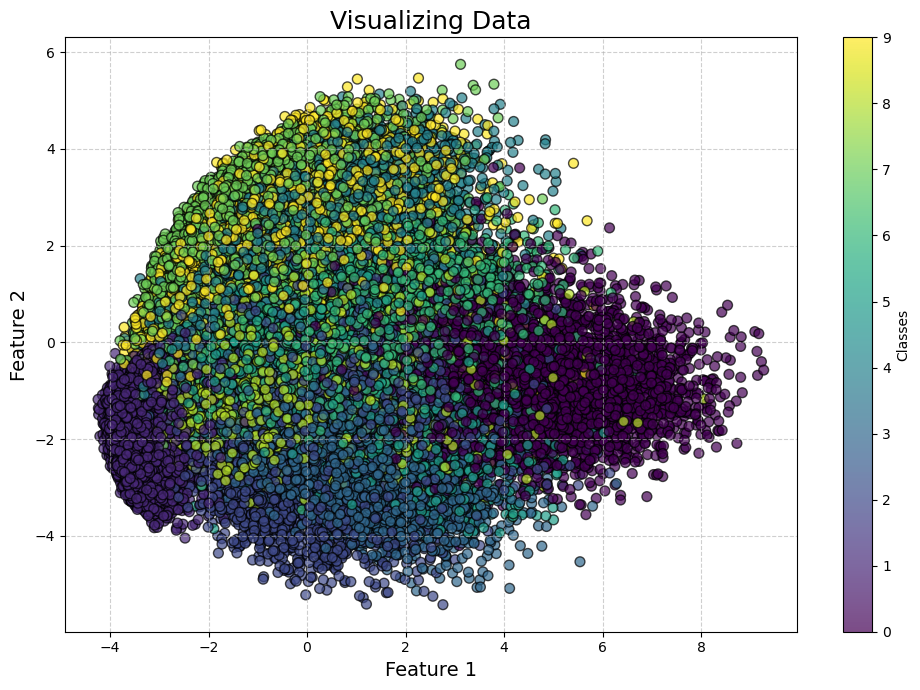

In [46]:
pca_two = decomposition.PCA(n_components=2)
X_viz_pca = pca_two.fit_transform(X_prep)

plt.figure(figsize=(10, 7))
plt.scatter(X_viz_pca[:, 0], X_viz_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k', alpha=0.7, s=50)
plt.title('Visualizing Data', fontsize=18)
plt.xlabel('Feature 1', fontsize=14)
plt.ylabel('Feature 2', fontsize=14)
plt.colorbar(label='Classes')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Dimensionality Reduction

In [167]:
pca = decomposition.PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_prep)

X_pca.shape

(60000, 331)

**Final Pipeline**

In [6]:
prep_pipe = pipeline.Pipeline([('flatten', Flatten),
                               ('scaler', preprocessing.StandardScaler())])

X_train_prep = prep_pipe.fit_transform(X_train)
X_test_prep = prep_pipe.transform(X_test)

**Balanced Labels**

In [30]:
distinct = {}

for label in np.unique(y_train):
    distinct.update({label:np.count_nonzero(y_train==label)/len(y_train)})

<BarContainer object of 10 artists>

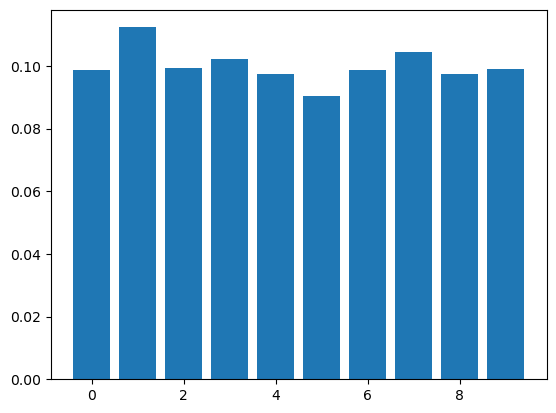

In [41]:
x_axis = list(distinct.keys())
y_axis = list(distinct.values())
plt.bar(x_axis, y_axis)

### Binary Classification

In [58]:
y_binary_train = np.int64(y_train==0)
y_binary_test = np.int64(y_test==0)
np.unique(y_binary_train)

array([0, 1])

In [60]:
y_train[1], y_binary_train[1]

(0, 1)

In [193]:
dt_clf = tree.DecisionTreeClassifier()  # Decision Tree (zero expectations from this lol)
lin_svc = svm.LinearSVC()               # Linear SVM Classifier
sfmx_clf = linear_model.LogisticRegression(multi_class='multinomial')    # Softmax Regression
rf_clf = ensemble.RandomForestClassifier()                      # Random Forest Classifier with 100 trees
sgd_clf = linear_model.SGDClassifier()                          # SGD Classifier

shortlist = [dt_clf, lin_svc, sfmx_clf, rf_clf, sgd_clf]

In [196]:
initial_run_scores = {}

for model in shortlist:
    score = model_selection.cross_val_score(model, X_train_prep, y_train, cv=3, n_jobs=-1)
    initial_run_scores.update({model: score.mean()})
    print(model, score)
    

DecisionTreeClassifier() [0.8552  0.85965 0.86235]
LinearSVC() [0.89885 0.90065 0.9033 ]
LogisticRegression(multi_class='multinomial') [0.90595 0.9081  0.91005]
RandomForestClassifier() [0.96405 0.9635  0.96675]
SGDClassifier() [0.90145 0.89365 0.904  ]


Pretty impressive how an un-tuned Random Forest Classifier with 100 trees achieves a validation accuracy of around 96%. I straight reject SGDClassifier, the scores are not the best, plus it's computational complexity for this task is a headache. I also reject DecisionTreeClassifier, which a no-brainer looking at the scores. Before deciding on a model, let me also give a shot to **kernel SVC** - large number of features and most of them sparse - SVM's favorite conditions.

Having said that, the Random Forest Classifier can be used for taking a look at feature importances.

**Feature Importances**

In [ ]:
rf_clf = ensemble.RandomForestClassifier(n_estimators=50)
rf_clf.fit(X_train_prep, y_train)

Text(0.5, 1.0, 'Feature Importances')

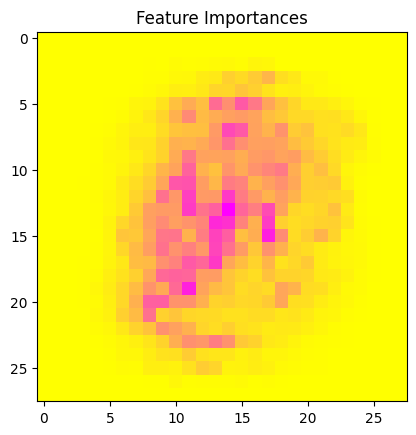

In [41]:
feature_imp_matrix = rf_clf.feature_importances_.reshape(28,28)
plt.imshow(feature_imp_matrix, cmap='spring_r')
plt.title('Feature Importances')

As is obvious, the most important and decisive pixels lie at the center(pink), the yellow pixels near boundaries have little importance in predictions; remember that our PCA also revealed a similar insight. The boundaries may be dropped for faster training and prediction without significant decay in scores. Let us stick with full features for now.

In [6]:
svc = svm.SVC()
score_svm = model_selection.cross_val_score(svc, X_train_prep, y_train, cv=3, n_jobs=-1)

score_svm.mean()

0.9602666666666666

Okay, so **RBF SVM Classifier** perform just on par with Random Forest. Instead of using RFs standalone, I have decided to fine-tune this SVC. Finally, I also plan to feed this tuned SVC to a BaggingClassifier just to see how it performs since I have enough time and resources. Ensembling this model, though, might be a case of diminishing returns; but what's wrong in trying.

In [8]:
search_space = [{'C': [0.1, 1, 10],
                 'kernel':['rbf']},
                {'C':[0.1, 1, 10],
                 'kernel':['poly'],
                 'degree':[2,3,4],
                 'coef0':[0.0, 0.2]}]

grid_search = model_selection.GridSearchCV(svc, search_space, cv=5, n_jobs=-1, scoring='accuracy', verbose=4)

In [9]:
grid_search.fit(X_train_prep, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10], 'kernel': ['rbf']},
                         {'C': [0.1, 1, 10], 'coef0': [0.0, 0.2],
                          'kernel': ['poly']}],
             scoring='accuracy', verbose=4)

In [15]:
grid_search.best_params_, grid_search.best_score_

({'C': 10, 'coef0': 0.2, 'kernel': 'poly'}, 0.9782833333333334)

Almost 98% mean validation score! Nice. Score can be improved even further but due to computing power limitation, I'll stick with these parameters. Last thing I am going to do is feed 10 such **SVC(C=10, coef0=0.2, kernel=poly, degree=3)** classifiers to a Bagging Classifier.

In [21]:
svm_final = svm.SVC(**grid_search.best_params_)

bag_clf = ensemble.BaggingClassifier(estimator=svm_final, n_estimators=10, warm_start=True, n_jobs=-1, random_state=42)

In [22]:
bag_clf.fit(X_train_prep, y_train)

BaggingClassifier(estimator=SVC(C=10, coef0=0.2, kernel='poly'), n_jobs=-1,
                  random_state=42, warm_start=True)

In [42]:
bag_clf.score(X_test_prep, y_test)

0.9811

The BaggingClassifier with 10 SVMs lives upto the hype : **98.11 % accuracy** on the test set!


Kartik Kumar
For more projects, please visit [My GithHub Page](https://github.com/ryuukkk)